# Importações

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from utilsforecast.plotting import plot_series
from datetime import date, timedelta
import calendar
from coreforecast.scalers import boxcox_lambda, boxcox, inv_boxcox
from scipy.stats import entropy
import os
import glob
import pickle

c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conexão

In [3]:
df_daily_filled = pd.read_csv('../df_daily_filled.csv', parse_dates=['detected'], dtype='int32')
df_daily_filled = df_daily_filled.set_index('detected')
df_daily_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-08-01 to 2024-02-29
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   943 non-null    int32
 1   count_2       943 non-null    int32
 2   direction_3   943 non-null    int32
 3   count_3       943 non-null    int32
 4   direction_4   943 non-null    int32
 5   count_4       943 non-null    int32
 6   direction_5   943 non-null    int32
 7   count_5       943 non-null    int32
 8   direction_6   943 non-null    int32
 9   count_6       943 non-null    int32
 10  direction_7   943 non-null    int32
 11  count_7       943 non-null    int32
 12  direction_8   943 non-null    int32
 13  count_8       943 non-null    int32
 14  direction_9   943 non-null    int32
 15  count_9       943 non-null    int32
 16  direction_10  943 non-null    int32
 17  count_10      943 non-null    int32
 18  direction_11  943 non-null    int32
 19  count_11  

In [4]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df_daily_filled.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

            direction_2  count_2  direction_3  count_3  direction_4  count_4  \
detected                                                                       
2021-08-01          219      327          155      323          138      424   
2021-08-02          144      252          194      381          117

### Datas especiais

In [5]:
def calcular_pascoa(ano):
    """Calcula a data da Páscoa para um dado ano (algoritmo de Meeus/Jones/Butcher)."""
    a = ano % 19
    b = ano // 100
    c = ano % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    mes = (h + l - 7 * m + 114) // 31
    dia = ((h + l - 7 * m + 114) % 31) + 1
    return date(ano, mes, dia)

#feriados 
def calcular_feriados_portugal(anos, incluir_lisboa=False):
    feriados = []

    for ano in anos:
        # Feriados
        feriados += [
            date(ano, 1, 1),   # Ano Novo
            date(ano, 4, 25),  # Dia da Liberdade
            date(ano, 5, 1),   # Dia do Trabalhador
            date(ano, 6, 10),  # Dia de Portugal
            date(ano, 8, 15),  # Assunção de Nossa Senhora
            date(ano, 10, 5),  # Implantação da República
            date(ano, 11, 1),  # Dia de Todos os Santos
            date(ano, 12, 1),  # Restauração da Independência
            date(ano, 12, 8),  # Imaculada Conceição
            date(ano, 12, 25), # Natal
            date(ano, 6, 13),  # Santo António
        ]

        # Feriados Domingo de Páscoa
        pascoa = calcular_pascoa(ano)
        feriados += [
            pascoa - timedelta(days=47), # Carnaval
            pascoa - timedelta(days=2),  # Sexta-feira Santa
            pascoa + timedelta(days=1),  # Segunda-feira de Páscoa 
            pascoa + timedelta(days=60), # Corpo de Deus
        ]

    return set(feriados)

In [6]:
anos = df_daily_filled.index.year.unique()
feriados = calcular_feriados_portugal(anos, incluir_lisboa=True)

df_daily_filled['holiday'] = df_daily_filled.index.date
df_daily_filled['holiday'] = df_daily_filled['holiday'].apply(
    lambda x: 1 if x in feriados else 0
)

In [7]:
#fim de semana
df_daily_filled['weekend'] = df_daily_filled.index.weekday.isin([5, 6]).astype(int)
df_daily_filled['exog'] = ((df_daily_filled['holiday'] == 1) | (df_daily_filled['weekend'] == 1)).astype(int)

# MSTL forecast

In [8]:
def fill_zeros(df, max_weeks_back=5):
    df_filled = df.copy()
    for col in df_daily_filled.columns:
        if col.startswith('count_'):
            zero_dates = df_daily_filled[df_daily_filled[col] == 0].index
            for datetime in zero_dates:
                for weeks_back in range(1, max_weeks_back + 1):
                    prev_week = datetime - pd.Timedelta(weeks=weeks_back)
                    if prev_week in df_daily_filled.index:
                        prev_value = df_daily_filled.loc[prev_week, col]
                        if prev_value != 0:
                            df_filled.loc[datetime, col] = prev_value
                            break
    return df_filled

In [9]:
def aplica_algoritmo(df, contador_id, exog_col='exog',
                     start_date='2021-08-01', end_date='2022-08-01',
                     season_length=[7], n_jobs=-1, datas_corrigidas_previamente=None):
    
    if contador_id is None:
        raise ValueError("É necessário especificar o 'contador_id'.")
    
    if contador_id not in df_daily_filled.columns:
        raise ValueError(f"Contador {contador_id} não encontrado no DataFrame.")
    
    if exog_col not in df_daily_filled.columns:
        raise ValueError(f"Coluna exógena {exog_col} não encontrada no DataFrame.")
    
    if datas_corrigidas_previamente is None:
        datas_corrigidas_previamente = set()
    
    # 1. Filtrar dados históricos até à data limite
    df_hist = df.loc[start_date:end_date].copy()
    df_hist[contador_id] = df_hist[contador_id].astype(float)

    # 2. Substituir dias com zeros 
    df_hist_corr = fill_zeros(df_hist)
    

    # 3. Preparar dados para StatsForecast
    unique_id = contador_id
    df_model = df_hist_corr[[contador_id, exog_col]].reset_index().assign(unique_id=unique_id)
    df_model.columns = ['ds', 'y', 'X', 'unique_id']
    df_model = df_model[['unique_id', 'ds', 'y', 'X']]

    # 4. Ajustar o modelo
    model = MSTL(season_length=season_length, trend_forecaster=AutoARIMA())
    sf = StatsForecast(models=[model], freq='D', n_jobs=n_jobs)
    sf.fit(df_model)
    
    
    # 5. Previsão (1 dia à frente apenas, para completar fitting)
    future_dates = pd.date_range(start=df_model['ds'].max() + pd.Timedelta(days=1), periods=1, freq='D')
    future_exog_values = [1 if d.date() in feriados else 0 for d in future_dates]

    future_exog = pd.DataFrame({
        'ds': future_dates,
        'X': future_exog_values,
        'unique_id': [contador_id] * len(future_dates)      
    })

    levels=[99.7]
    sf.forecast(df=df_model, X_df=future_exog, h=1, level=levels, fitted=True)

    # 6. Obter previsões in-sample e identificar outliers
    insample_fcst = sf.forecast_fitted_values()
    insample_fcst.columns = ['unique_id', 'ds', 'y', 'fitted', 'lo_99_7', 'hi_99_7']

    anomalies = insample_fcst[
        ~insample_fcst['y'].between(insample_fcst['lo_99_7'], insample_fcst['hi_99_7'])
    ].copy()

    novas_datas_corrigidas = set()

    # 7. Corrigir anomalias
    for _, row in anomalies.iterrows():
        dia = row['ds']
        
        if dia in datas_corrigidas_previamente or dia in novas_datas_corrigidas:
            continue

        y = row['y']
        hi = row['hi_99_7']
        lo = row['lo_99_7']
        historico = df_hist_corr.loc[df_hist_corr.index < dia, contador_id]

        if historico.empty:
            continue

        max_hist = historico.max()

        if y > hi:
            novo_valor = min(hi, max_hist)
        elif y < lo:
            novo_valor = lo
        else:
            continue

        df_hist_corr.loc[dia, contador_id] = novo_valor
        novas_datas_corrigidas.add(dia)


    # 9. Retornar histórico corrigido, anomalias, datas corrigidas e componente semanal
    return df_hist_corr, anomalies, novas_datas_corrigidas

In [10]:
def get_one_more_week_rolling(df, df_hist, weeks_added, janela_semanas=52):
    last_date = df_hist.index.max()
    next_week_start = last_date + pd.Timedelta(days=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    df_next_week = df.loc[next_week_start:next_week_end]

    if df_next_week.empty:
        return df_hist, weeks_added, False

    # Concatenar nova semana
    df_hist_updated = pd.concat([df_hist, df_next_week])

    # Manter janela de tamanho fixo (em semanas)
    dias_janela = janela_semanas * 7
    min_date = df_hist_updated.index.max() - pd.Timedelta(days=dias_janela - 1)
    df_hist_updated = df_hist_updated[df_hist_updated.index >= min_date]

    return df_hist_updated, weeks_added + 1, True

In [11]:
resultados_corrigidos = [] # <- quando for para todos os contadores esta linha e as 2 proximas não são necessarias
todas_anomalias = []
datas_corrigidas_global = set()

contador_id = 'count_35' # <- quando for para todos os contadores tem de ser eliminada
exog_col = 'exog'
start_date = '2021-08-01'
end_date_inicial = '2022-07-31'
#max_semanas = 2
semanas_adicionadas = 0 #quando for para todos os contadores tem de ser eliminada

# for contador_id in colunas_contadores:  <- par todos os contadores
#     if not contador_id.startswith("count_"):
#         continue  # ignora colunas que não são contadores

#     print(f"\n### PROCESSANDO {contador_id} ###")

#     resultados_corrigidos = []
#     todas_anomalias = []
#     datas_corrigidas_global = set()
#     semanas_adicionadas = 0

    # Aplicar primeira vez
df_hist_atual, anomalies_iniciais, datas_corrigidas = aplica_algoritmo(
    df=df_daily_filled,
    contador_id=contador_id,
    exog_col=exog_col,
    start_date=start_date,
    end_date=end_date_inicial,
    datas_corrigidas_previamente=datas_corrigidas_global
)

    # Atualizar listas
datas_corrigidas_global.update(datas_corrigidas)
resultados_corrigidos.append(df_hist_atual.copy())
todas_anomalias.append(anomalies_iniciais)

    # Loop
while True:    
#while semanas_adicionadas < max_semanas:
    df_hist_atual, semanas_adicionadas, conseguiu_adicionar = get_one_more_week_rolling(
        df=df_daily_filled,
        df_hist=df_hist_atual,
        weeks_added=semanas_adicionadas,
        #max_weeks=max_semanas
        janela_semanas=52  # ou outro valor
    )

    if not conseguiu_adicionar:
        print("Não há mais semanas para adicionar.")
        break

    df_corrigido, novas_anomalias, novas_datas_corrigidas = aplica_algoritmo(
        df=df_hist_atual,
        contador_id=contador_id,
        exog_col=exog_col,
        start_date=start_date,
        end_date=df_hist_atual.index.max().strftime('%Y-%m-%d'),
        datas_corrigidas_previamente=datas_corrigidas_global
    )

    # Filtrar anomalias para ignorar as que já foram corrigidas antes
    novas_anomalias = novas_anomalias[~novas_anomalias['ds'].isin(datas_corrigidas_global)].copy()

    # Atualizar conjunto global das datas corrigidas
    datas_corrigidas_global.update(novas_datas_corrigidas)

    df_hist_atual = df_corrigido.copy()
    resultados_corrigidos.append(df_hist_atual.copy())
    todas_anomalias.append(novas_anomalias)

    print(f"Semana {semanas_adicionadas} processada com {len(novas_anomalias)} novos outliers.")

Semana 1 processada com 2 novos outliers.
Semana 2 processada com 2 novos outliers.
Semana 3 processada com 0 novos outliers.
Semana 4 processada com 0 novos outliers.
Semana 5 processada com 0 novos outliers.
Semana 6 processada com 1 novos outliers.
Semana 7 processada com 0 novos outliers.
Semana 8 processada com 0 novos outliers.
Semana 9 processada com 1 novos outliers.
Semana 10 processada com 0 novos outliers.
Semana 11 processada com 0 novos outliers.
Semana 12 processada com 1 novos outliers.
Semana 13 processada com 0 novos outliers.
Semana 14 processada com 1 novos outliers.
Semana 15 processada com 0 novos outliers.
Semana 16 processada com 0 novos outliers.
Semana 17 processada com 0 novos outliers.
Semana 18 processada com 0 novos outliers.
Semana 19 processada com 0 novos outliers.
Semana 20 processada com 1 novos outliers.
Semana 21 processada com 0 novos outliers.
Semana 22 processada com 1 novos outliers.
Semana 23 processada com 0 novos outliers.
Semana 24 processada

In [12]:

pasta_resultados = "resultados_corrigidos"
os.makedirs(pasta_resultados, exist_ok=True)

dados_a_guardar = {
    "corrigido": resultados_corrigidos,
    "anomalias": todas_anomalias
}

filename = os.path.join(pasta_resultados, f"resultado_{contador_id}.pkl")
with open(filename, "wb") as f:
    pickle.dump(dados_a_guardar, f)




In [13]:

pasta_resultados = "resultados_corrigidos"
ficheiros = glob.glob(os.path.join(pasta_resultados, "resultado_count_*.pkl"))

lista_dfs_corrigidos = []
lista_dfs_anomalias = []

for ficheiro in ficheiros:
    nome = os.path.basename(ficheiro)
    contador_id = nome.replace("resultado_", "").replace(".pkl", "")

    with open(ficheiro, "rb") as f:
        dados = pickle.load(f)

    # Parte corrigida
    lista_resultados_corrigidos = dados["corrigido"]
    df_corrigido = pd.concat(lista_resultados_corrigidos, axis=0)
    df_corrigido = df_corrigido[[contador_id]]
    lista_dfs_corrigidos.append(df_corrigido)

    # Parte das anomalias
    lista_anomalias = dados["anomalias"]
    df_anomalias = pd.concat(lista_anomalias, ignore_index=True)
    df_anomalias["contador"] = contador_id  # identificar o contador
    lista_dfs_anomalias.append(df_anomalias)

# Juntar tudo num único DataFrame
df_corrigido_total = pd.concat(lista_dfs_corrigidos, axis=1)
df_corrigido_total = df_corrigido_total[~df_corrigido_total.index.duplicated(keep="last")]

df_anomalias_total = pd.concat(lista_dfs_anomalias, ignore_index=True)

# Prontos para análise:
display(df_corrigido_total.head())
display(df_anomalias_total)



,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_19,count_2,...,count_32,count_33,count_34,count_35,count_4,count_5,count_6,count_7,count_8,count_9
detected,,,,,,,,,,,,,,,,,,,,,
2021-08-01,407.0,141.0,1663.0,308.0,121.0,84.0,830.0,279.0,638.0,327.0,...,500.0,769.0,691.0,1149.0,424.0,341.0,673.0,1092.0,106.0,1400.0
2021-08-02,219.0,112.0,1272.0,456.0,116.0,83.0,937.0,349.0,462.0,252.0,...,486.0,590.0,777.0,1163.0,372.0,364.0,907.0,1350.0,91.0,632.0
2021-08-03,245.0,155.0,1152.0,488.0,125.0,104.0,1073.0,391.0,539.0,257.0,...,568.0,699.0,724.0,1194.0,411.0,431.0,914.0,1347.0,115.0,860.0
2021-08-04,300.0,135.0,1182.0,448.0,105.0,99.0,1103.0,370.0,600.0,266.0,...,563.0,626.0,799.0,1236.0,423.0,404.0,890.0,1451.0,104.0,903.0
2021-08-05,246.0,144.0,1125.0,382.0,121.0,88.0,1042.0,338.0,471.0,259.0,...,584.0,602.0,846.0,1245.0,370.0,370.0,887.0,1342.0,107.0,823.0


,unique_id,ds,y,fitted,lo_99_7,hi_99_7,contador
0,count_10,2021-10-31,112.0,267.268474,126.957569,407.579378,count_10
1,count_10,2021-11-28,707.0,350.914460,210.603555,491.225364,count_10
2,count_10,2022-03-20,104.0,278.085172,137.774268,418.396077,count_10
3,count_10,2021-10-29,107.0,237.029712,113.291231,360.768194,count_10
4,count_10,2021-12-20,66.0,199.620194,75.881712,323.358675,count_10
...,...,...,...,...,...,...,...
1008,count_9,2023-08-05,634.0,1300.396207,650.834772,1949.957642,count_9
1009,count_9,2023-08-07,3229.0,1020.153601,305.441314,1734.865889,count_9
1010,count_9,2023-08-08,619.0,1838.649650,1123.937363,2553.361938,count_9
1011,count_9,2022-12-25,159.0,756.109013,200.858145,1311.359882,count_9


In [14]:
display(df_anomalias_total[df_anomalias_total['unique_id']== 'count_34'])

,unique_id,ds,y,fitted,lo_99_7,hi_99_7,contador
767,count_34,2021-10-01,296.0,1033.316295,507.934374,1558.698215,count_34
768,count_34,2021-12-20,381.0,1078.084510,552.702590,1603.466431,count_34
769,count_34,2022-03-18,1822.0,1294.318614,768.936693,1819.700534,count_34
770,count_34,2022-04-25,2575.0,1743.814349,1218.432429,2269.196270,count_34
771,count_34,2022-06-12,2252.0,1638.605720,1113.223799,2163.987640,count_34
772,count_34,2021-10-04,354.0,929.220240,433.466803,1424.973676,count_34
773,count_34,2021-12-24,414.0,939.521281,443.767845,1435.274718,count_34
774,count_34,2022-03-20,739.0,1410.442732,914.689296,1906.196169,count_34
775,count_34,2022-08-08,125.0,1582.170516,1023.619958,2140.721074,count_34
776,count_34,2022-08-09,1732.0,1086.054551,527.503993,1644.605109,count_34


In [15]:
# Selecionar os três primeiros contadores (podes trocar os nomes)
contadores_para_mostrar = ['count_34', 'count_13', 'count_14']

for contador in contadores_para_mostrar:
    fig = px.line(
        df_corrigido_total,
        y=contador,
        title=f"Contagem corrigida – {contador}",
        labels={"index": "Data", contador: "Contagem"},
    )
    fig.update_layout(width=1900, height=350)
    fig.show()



### Métodos tradicionais

In [ ]:
def calcular_sr_si(df, coluna='count_', plotar=True):
    df = df.copy()
    df.columns = ['datetime', coluna]
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extrair ano e semana ISO
    df['ano'] = df['datetime'].dt.isocalendar().year
    df['semana'] = df['datetime'].dt.isocalendar().week

    # 1) SR agregado por semana (todos os anos juntos)
    df_sr_semana = df.groupby('semana')[coluna].agg(['mean', 'max']).reset_index()
    df_sr_semana.rename(columns={'mean': 'media_semanal', 'max': 'max_semanal'}, inplace=True)
    df_sr_semana['SR'] = df_sr_semana['max_semanal'] / df_sr_semana['media_semanal']

    # df_semana agora tem SR para cada semana, agregado (todos os anos juntos)

    # 2) SR separado por ano e semana
    df_sr_ano_semana = df.groupby(['ano', 'semana'])[coluna].agg(['mean', 'max']).reset_index()
    df_sr_ano_semana.rename(columns={'mean': 'media_semanal', 'max': 'max_semanal'}, inplace=True)
    df_sr_ano_semana['SR'] = df_sr_ano_semana['max_semanal'] / df_sr_ano_semana['media_semanal']

    resultados_si = []
    for ano, grupo in df_sr_ano_semana.groupby('ano'):
        media_sr = grupo['SR'].mean()
        max_sr = grupo['SR'].max()
        si = media_sr / max_sr if max_sr != 0 else None
        resultados_si.append({
            'ano': ano,
            'SI': round(si, 4) if si is not None else None,
            'SR_medio': round(media_sr, 4),
            'SR_max': round(max_sr, 4)
        })

    df_si = pd.DataFrame(resultados_si).sort_values('ano').reset_index(drop=True)


    if plotar:
        plt.figure(figsize=(12, 12))

        plt.subplot(3, 1, 1)
        for ano in sorted(df_sr_ano_semana['ano'].unique()):
            subset = df_sr_ano_semana[df_sr_ano_semana['ano'] == ano].sort_values('semana')
            plt.plot(subset['semana'], subset['SR'], marker='o', linestyle='-', label=f'Ano {ano}', alpha=0.7)
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.xlim(1, 53)
        plt.title('Seasonality Ratio (SR) por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(df_sr_semana['semana'], df_sr_semana['SR'], marker='o', color='black')
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.title('Seasonality Ratio (SR) semanal (máximo/média)')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(df_si['ano'], df_si['SI'], marker='o', color='green', label='Seasonality Indicator (SI)')
        plt.axhline(1, color='red', linestyle='--', label='SI = 1 (sem sazonalidade)')
        plt.title('Seasonality Indicator (SI) por Ano')
        plt.xlabel('Ano')
        plt.ylabel('SI')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_sr_ano_semana, df_sr_semana, df_si

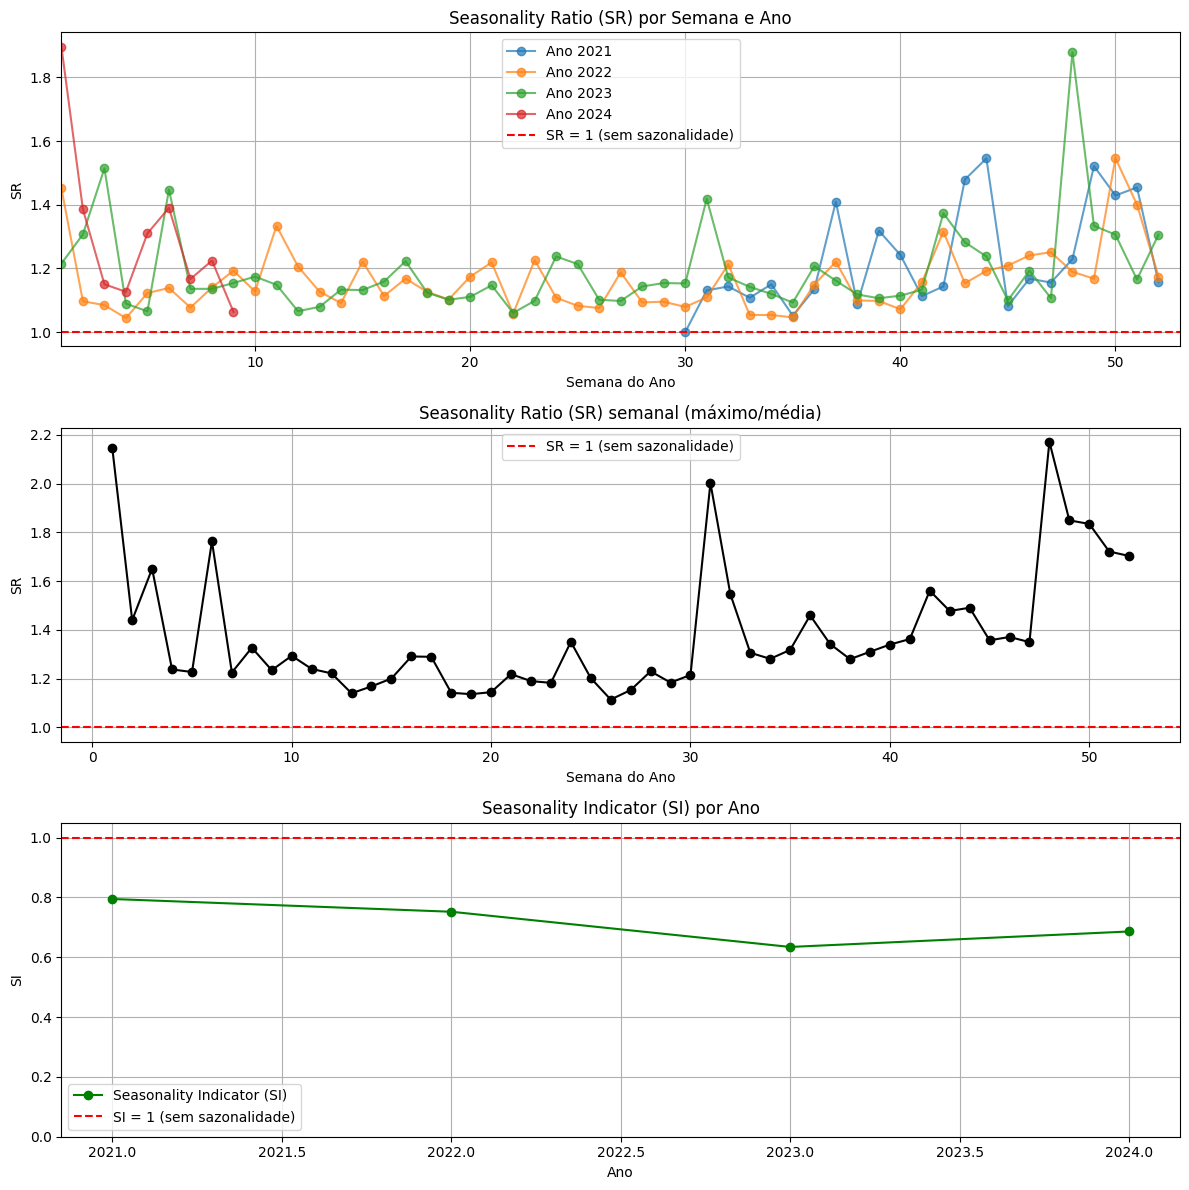

      ano  semana  media_semanal  max_semanal        SR
0    2021      30     691.000000        691.0  1.000000
1    2021      31     790.428571        894.0  1.131032
2    2021      32     830.857143        950.0  1.143398
3    2021      33     809.571429        897.0  1.107994
4    2021      34     919.000000       1057.0  1.150163
..    ...     ...            ...          ...       ...
131  2024       5    1120.428571       1468.0  1.310213
132  2024       6     978.857143       1361.0  1.390397
133  2024       7    1229.857143       1435.0  1.166802
134  2024       8    1198.000000       1467.0  1.224541
135  2024       9    1315.500000       1399.0  1.063474

[136 rows x 5 columns]
 
    semana  media_semanal  max_semanal        SR
0        1    1116.913116  2398.131887  2.147107
1        2    1103.189416  1588.000000  1.439463
2        3    1168.662566  1928.913884  1.650531
3        4    1193.047619  1476.000000  1.237168
4        5    1292.000000  1585.000000  1.226780
5       

In [17]:
df_diario = df_corrigido_total['count_34'].reset_index()
df_diario.columns = ['datetime', 'count_34']
df_sr_ano_semana, df_sr_semana, df_si = calcular_sr_si(df_diario, coluna='count_34', plotar=True)

print(df_sr_ano_semana)
print(' ')        
print(df_sr_semana)    
print(' ')  
print(df_si)  

In [18]:
y = df_corrigido_total['count_29']
y_boxcox = boxcox(y, lmbda=0)
best_lambda = boxcox_lambda(y, method='guerrero', season_length=7)
y_boxcox = boxcox(y, best_lambda)

In [19]:
inv_boxcox(y_boxcox, best_lambda).round(0)

array([ 356.,  341.,  315.,  354.,  349.,  361.,  308.,  299.,  348.,
        420.,  425.,  376.,  407.,  362.,  343.,  386.,  399.,  404.,
        383.,  388.,  378.,  344.,  363.,  427.,  459.,  433.,  434.,
        367.,  333.,  442.,  512.,  577.,  507.,  507.,  438.,  407.,
        502.,  530.,  487.,  508.,  493.,  408.,  434.,  436.,  470.,
        433.,  500.,  500.,  447.,  352.,  434.,  526.,  462.,  532.,
        486.,  423.,  379.,  511.,  498.,  527.,  584.,  580.,  460.,
        401.,  552.,  420.,  585.,  578.,  608.,  511.,  440.,  532.,
        543.,  573.,  580.,  558.,  535.,  435.,  577.,  688.,  637.,
        530.,  673.,  512.,  451.,  599.,  592.,  573.,  645.,  487.,
        359.,  372.,  484.,  514.,  557.,  713.,  637.,  469.,  493.,
        513.,  535.,  599.,  568.,  592.,  499.,  424.,  569.,  532.,
        585.,  582.,  641.,  523.,  442.,  437.,  549.,  523.,  486.,
        607.,  474.,  415.,  554.,  614.,  503.,  571.,  602.,  519.,
        431.,  587.,

In [20]:
stl = STL(y_boxcox, period=7)
decomp_stl = stl.fit()
df_decomp_stl = pd.DataFrame({
    'observed': inv_boxcox(decomp_stl.observed, best_lambda),
    'trend': inv_boxcox(decomp_stl.trend, best_lambda),
    'seasonal': inv_boxcox(decomp_stl.seasonal, best_lambda),
    'residual': inv_boxcox(decomp_stl.resid, best_lambda)
}, index=df_corrigido_total.index)

df_decomp_stl.head(15)

,observed,trend,seasonal,residual
detected,,,,
2021-08-01,356.000732,332.816270,0.999956,1.000415
2021-08-02,340.996429,334.448901,1.000025,1.000083
2021-08-03,314.998322,336.393518,0.999992,0.999628
2021-08-04,353.998169,338.597068,1.000346,0.999898
2021-08-05,349.000366,341.053492,1.000027,1.000100
2021-08-06,360.998260,343.799131,1.000263,1.000000
2021-08-07,307.997925,346.916565,0.999531,0.999784
2021-08-08,299.004028,351.238904,0.999676,0.999389
2021-08-09,348.001312,357.363882,0.999973,0.999884


,observed,trend,seasonal,residual,seasonadjust
detected,,,,,
2021-08-01,356.000732,332.816270,0.999956,1.000415,1.069661
2021-08-02,340.996429,334.448901,1.000025,1.000083,1.019577
2021-08-03,314.998322,336.393518,0.999992,0.999628,0.936398
2021-08-04,353.998169,338.597068,1.000346,0.999898,1.045485
2021-08-05,349.000366,341.053492,1.000027,1.000100,1.023301
...,...,...,...,...,...
2024-02-25,885.991089,998.884423,0.999688,1.000042,0.886981
2024-02-26,970.025818,990.564901,1.000015,0.999940,0.979265
2024-02-27,1045.017456,982.564939,1.000127,1.000003,1.063561


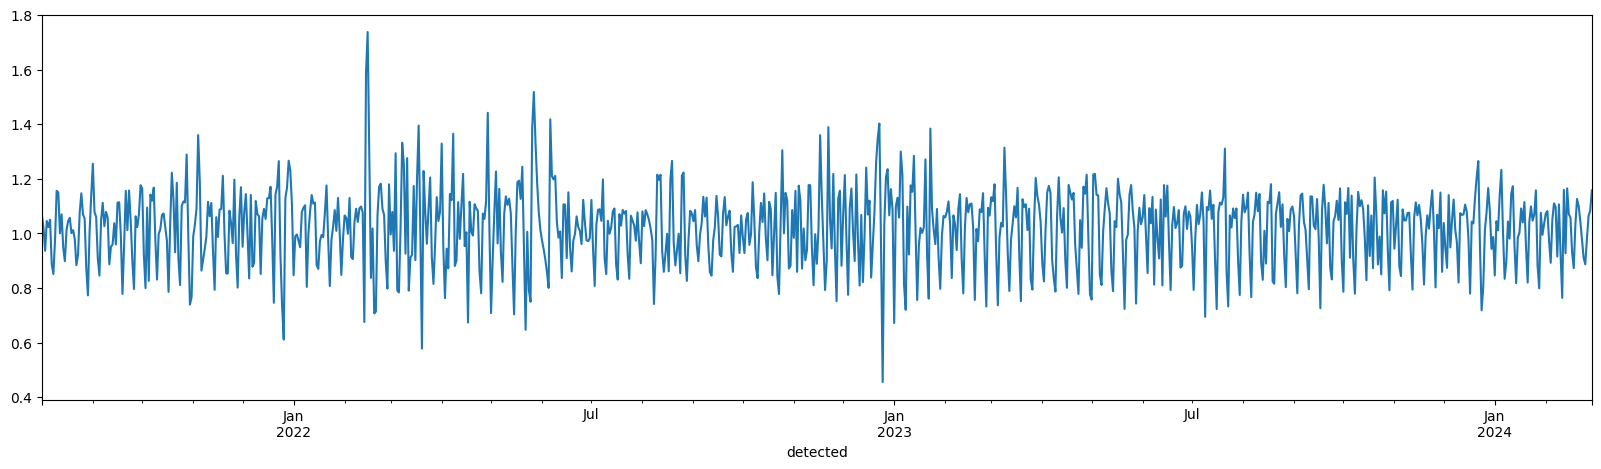

In [21]:
df_season_stl = df_decomp_stl.assign(seasonadjust = df_decomp_stl.observed / df_decomp_stl.trend)
df_season_stl.seasonadjust.plot(figsize=(20,5));
df_season_stl

In [22]:
df_sem_tendencia = pd.DataFrame({
    'datetime': df_decomp_stl.index,
    'count_29': df_season_stl['seasonadjust']
})

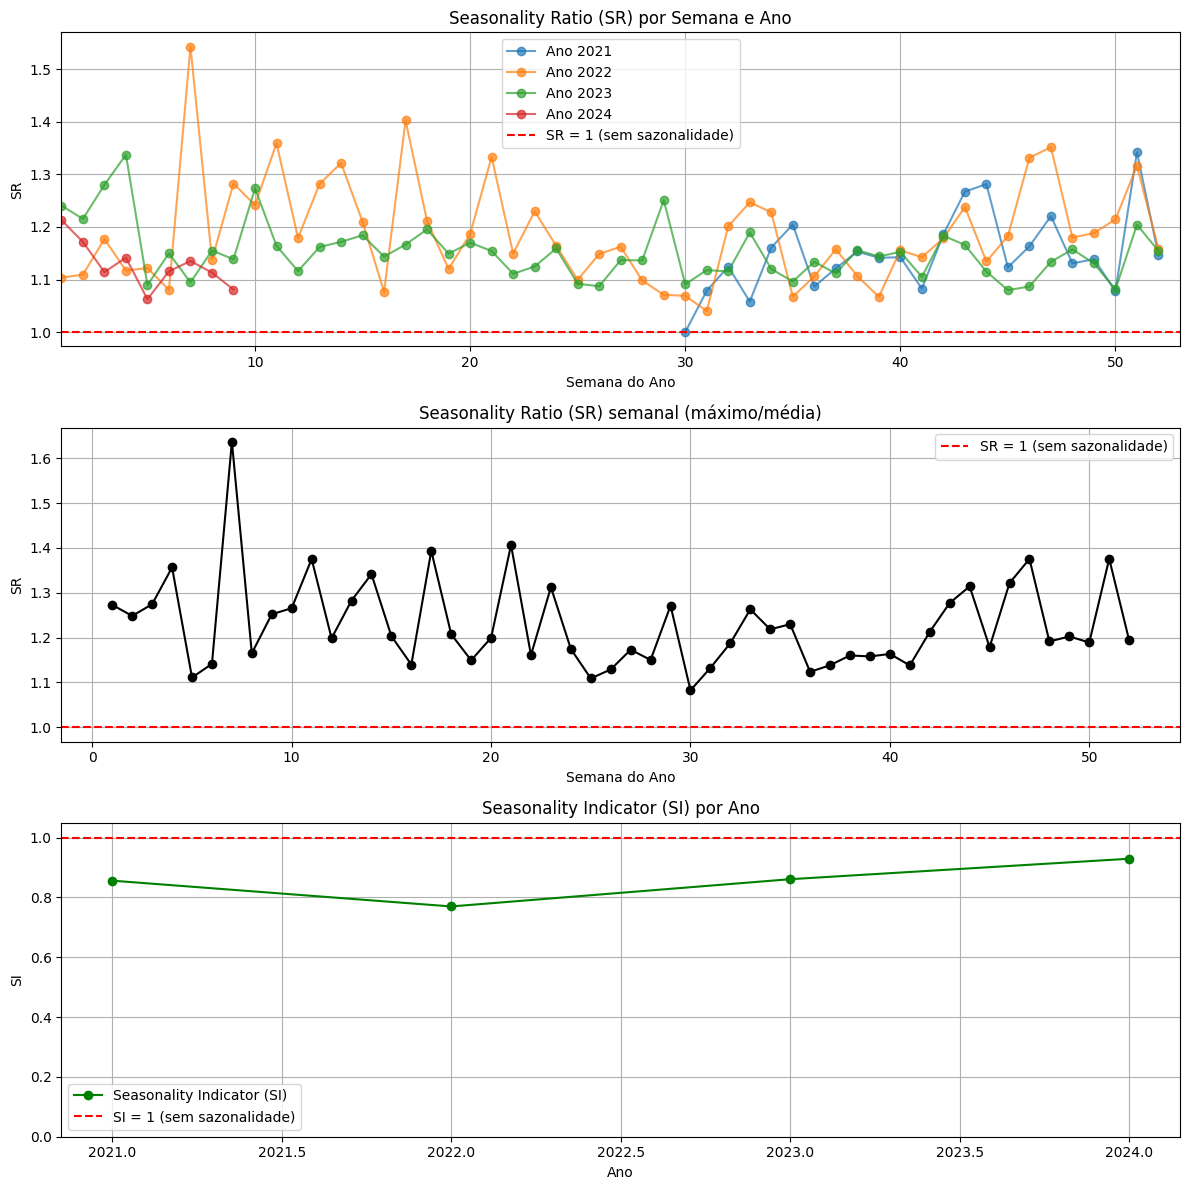

In [23]:
df_sr_ano_semana, df_sr_semana, df_si = calcular_sr_si(df_sem_tendencia, coluna='count_29', plotar=True)

### Indice de Gini (covariancia)

In [24]:
def gini_covariancia(y):
    y = np.array(y)
    n = len(y)
    if n == 0 or np.sum(y) == 0:
        return np.nan

    y_sorted = np.sort(y)
    F_y = (np.arange(1, n + 1)) / n  # função de distribuição empírica (percentis)
    y_mean = np.mean(y_sorted)

    cov = np.cov(y_sorted, F_y, bias=True)[0, 1]  # covariância com bias=True para dividir por n
    gini = (2 * cov) / y_mean
    return gini

In [45]:
def gini_cov_semanal(df, plotar=True):
    resultados = []

    for coluna in df.columns:
        df_temp = df[[coluna]].copy()  # NÃO alterar o df original!
        df_temp = df_temp.rename(columns={coluna: 'count'})
        df_temp['datetime'] = pd.to_datetime(df_temp.index)
        df_temp['ano'] = df_temp['datetime'].dt.isocalendar().year
        df_temp['semana'] = df_temp['datetime'].dt.isocalendar().week

        df_gini_cov = (
            df_temp.groupby(['ano', 'semana'])['count']
                   .apply(gini_covariancia)
                   .reset_index(name='gini')
        )

        df_gini_cov['semana_data'] = pd.to_datetime(
            df_gini_cov['ano'].astype(str) + '-W' + df_gini_cov['semana'].astype(str) + '-1',
            format='%G-W%V-%u',
            errors='coerce'
        )

        df_gini_cov['contador'] = coluna
        resultados.append(df_gini_cov)

        if plotar:
            plt.figure(figsize=(12, 4))
            plt.plot(df_gini_cov['semana_data'], df_gini_cov['gini'], marker='o')
            plt.title(f'Índice de Gini semanal (covariância) – {coluna}')
            plt.xlabel('Data (início da semana)')
            plt.ylabel('Gini')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return pd.concat(resultados, ignore_index=True)


In [47]:
df_resultado_gini = gini_cov_semanal(df_corrigido_total, plotar=False)
df_resultado_gini


,ano,semana,gini,semana_data,contador
0,2021,30,0.000000,2021-07-26,count_10
1,2021,31,0.083016,2021-08-02,count_10
2,2021,32,0.082172,2021-08-09,count_10
3,2021,33,0.062759,2021-08-16,count_10
4,2021,34,0.085822,2021-08-23,count_10
...,...,...,...,...,...
4211,2024,5,0.195202,2024-01-29,count_9
4212,2024,6,0.246664,2024-02-05,count_9
4213,2024,7,0.259700,2024-02-12,count_9
4214,2024,8,0.189747,2024-02-19,count_9


In [51]:
df_resultado_gini[df_resultado_gini['contador'] == 'count_12'] 

,ano,semana,gini,semana_data,contador
272,2021,30,0.000000,2021-07-26,count_12
273,2021,31,0.090872,2021-08-02,count_12
274,2021,32,0.049406,2021-08-09,count_12
275,2021,33,0.095398,2021-08-16,count_12
276,2021,34,0.095646,2021-08-23,count_12
...,...,...,...,...,...
403,2024,5,0.159268,2024-01-29,count_12
404,2024,6,0.196258,2024-02-05,count_12
405,2024,7,0.181666,2024-02-12,count_12
406,2024,8,0.116765,2024-02-19,count_12


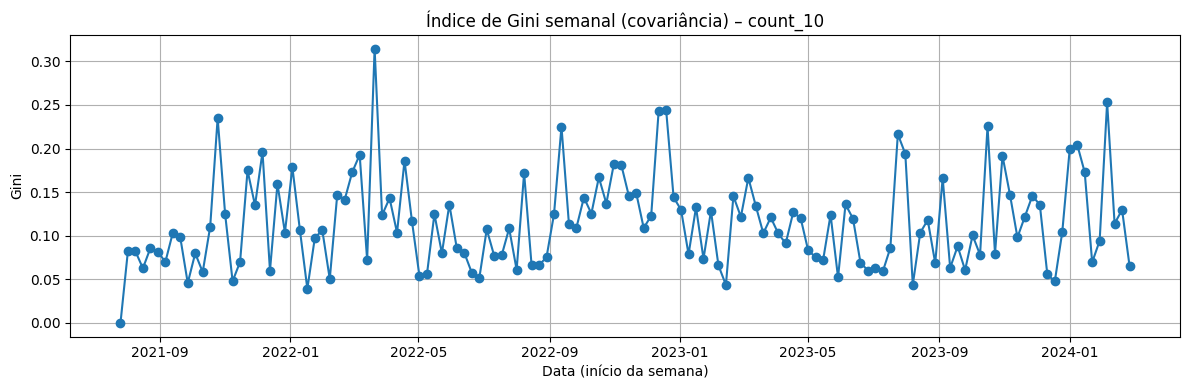

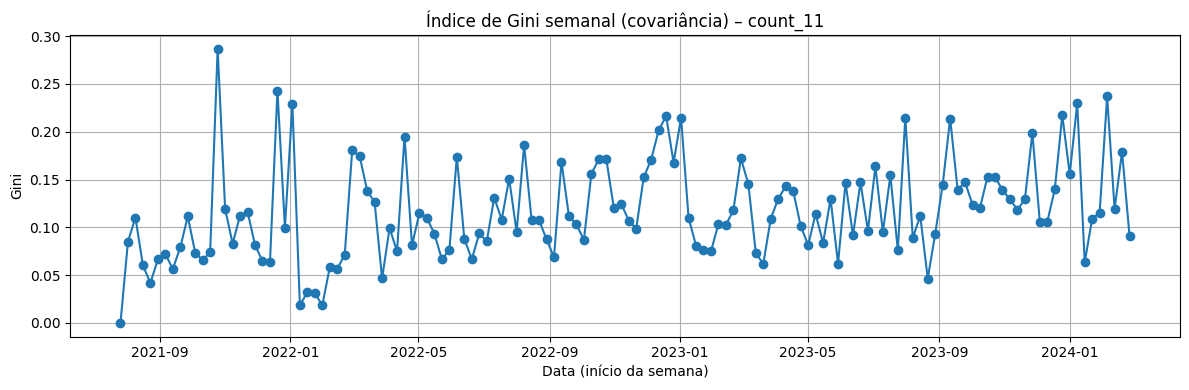

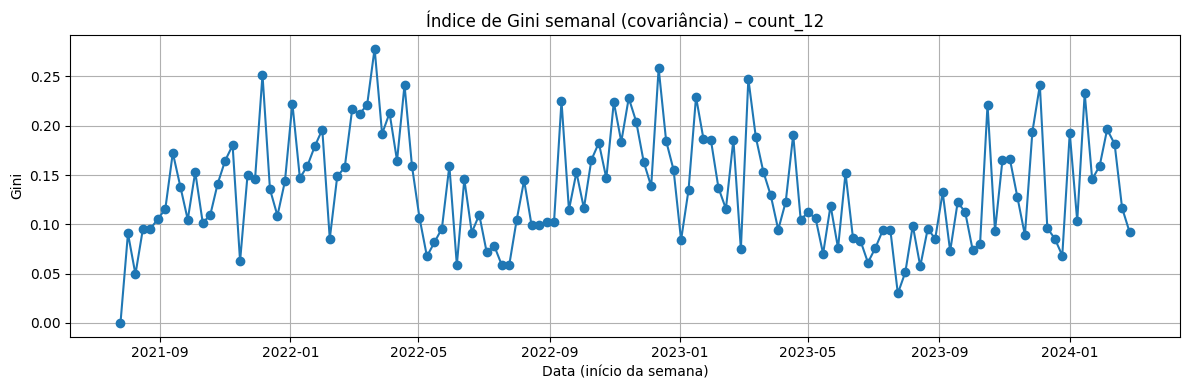

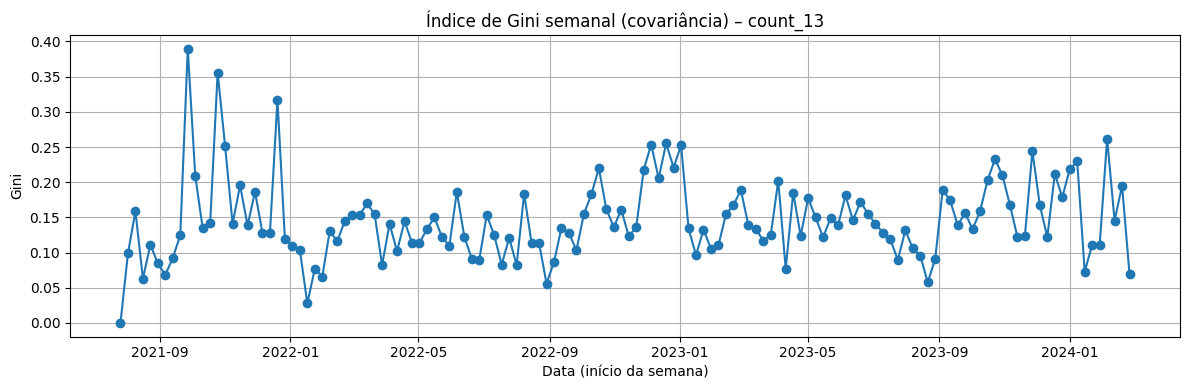

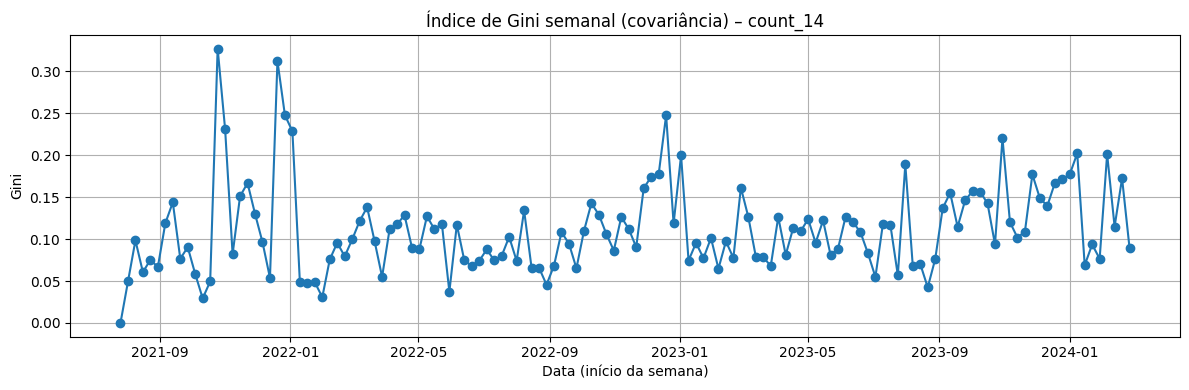

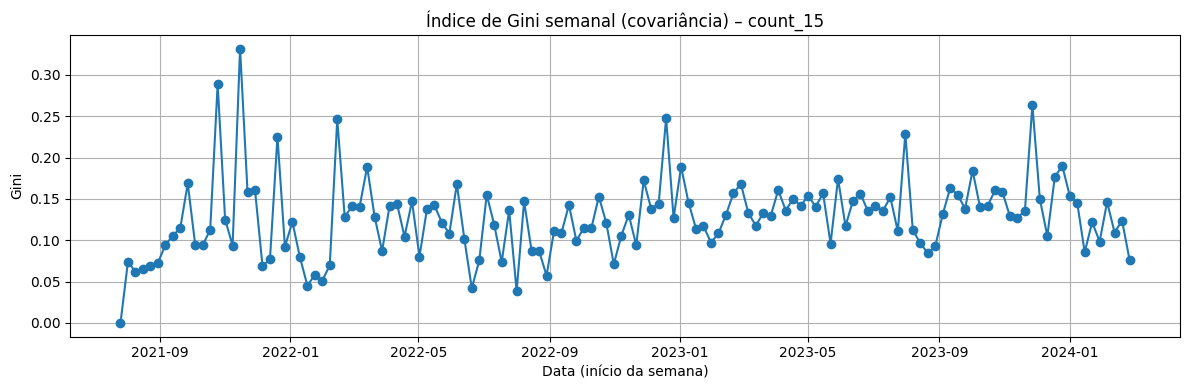

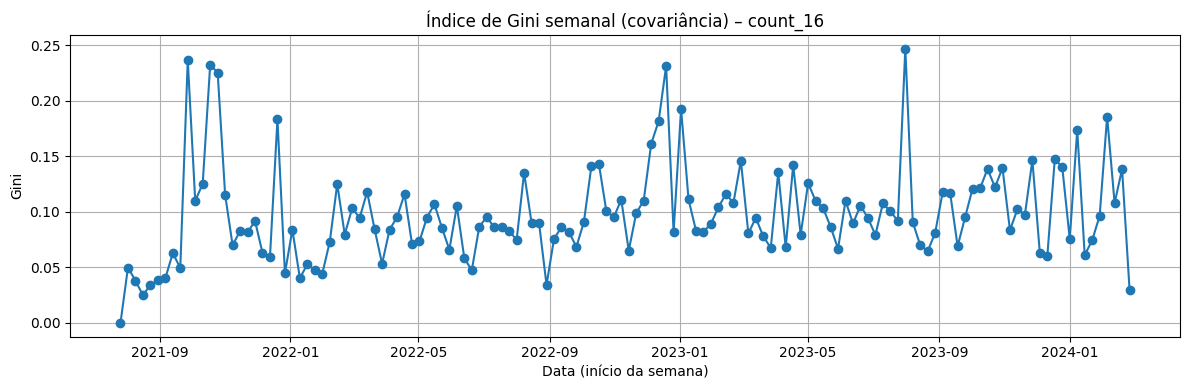

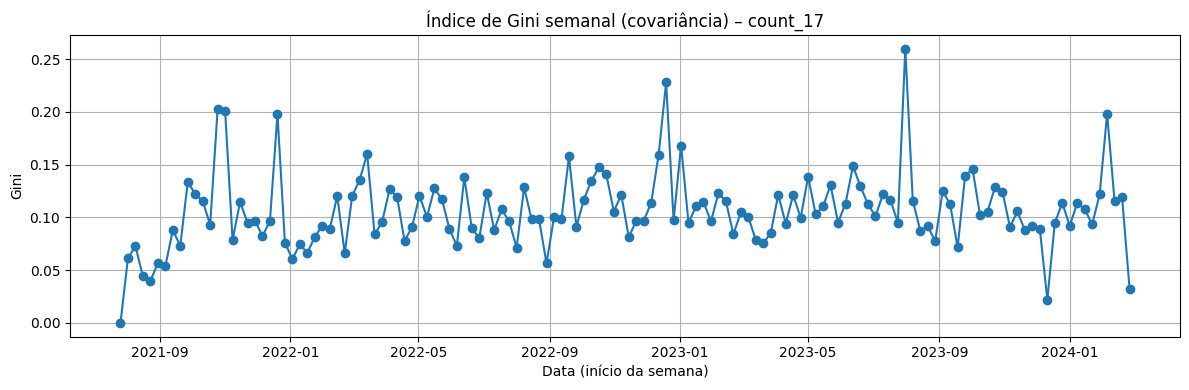

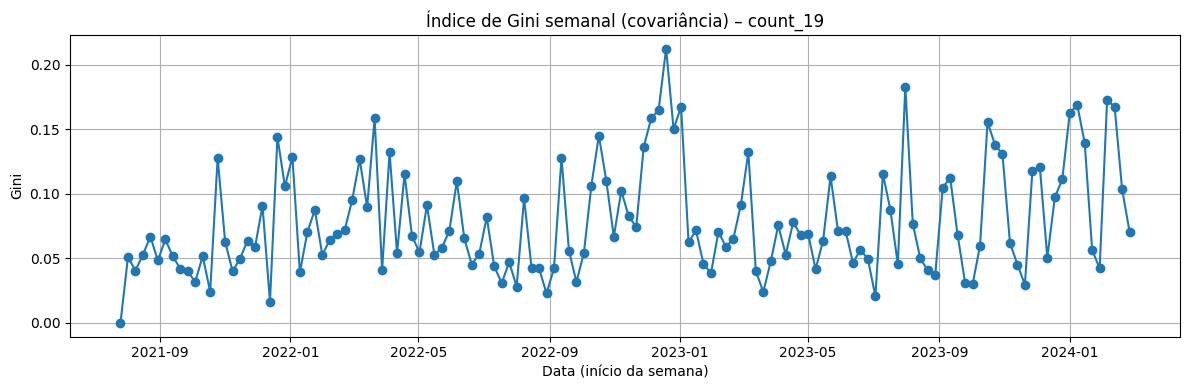

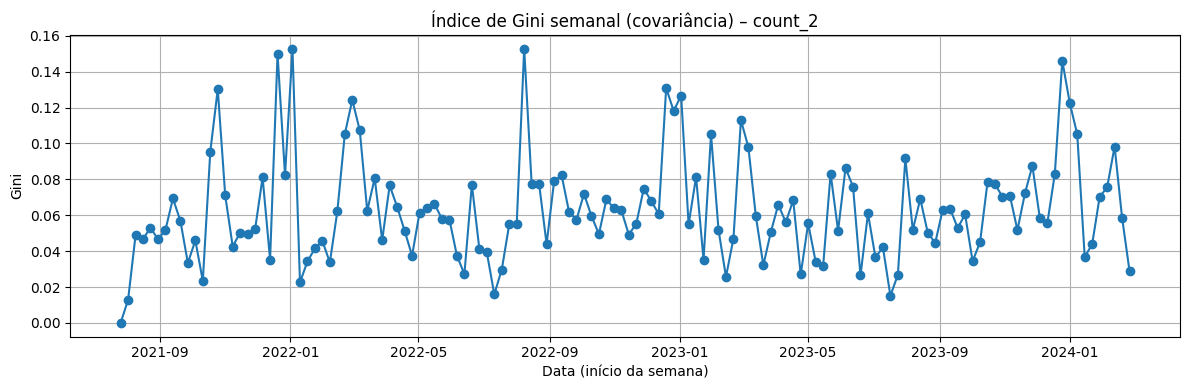

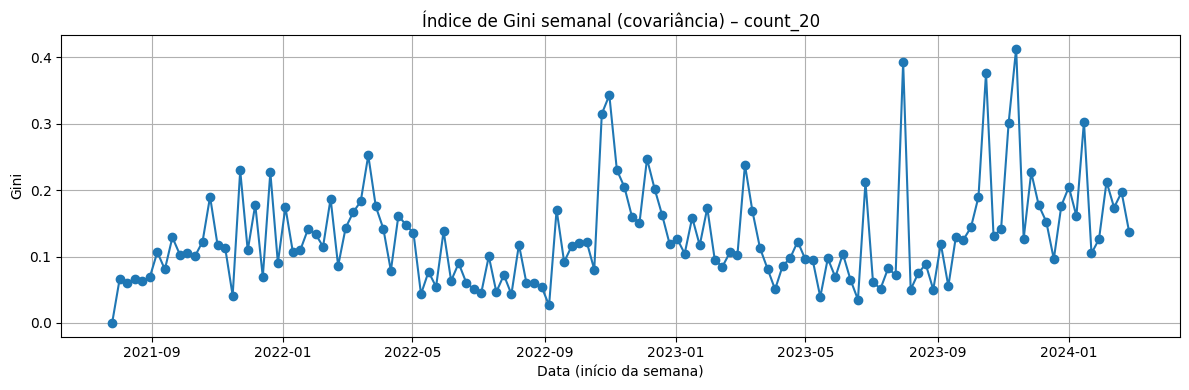

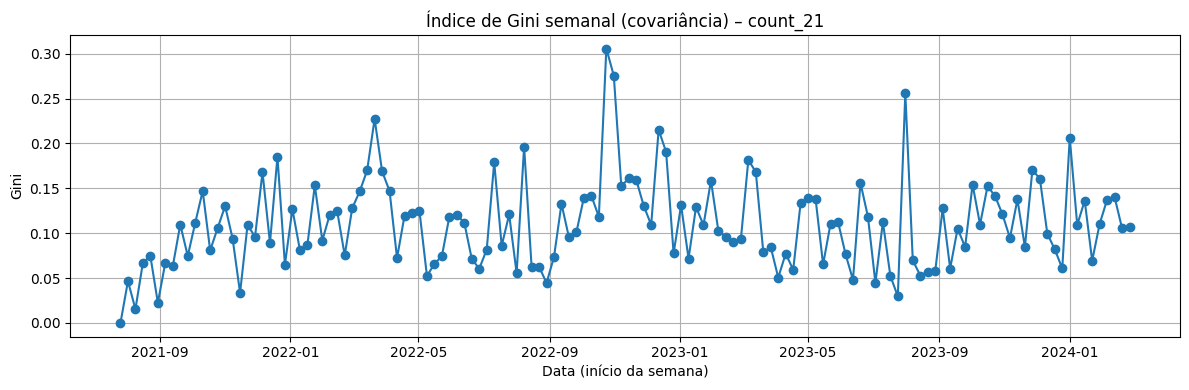

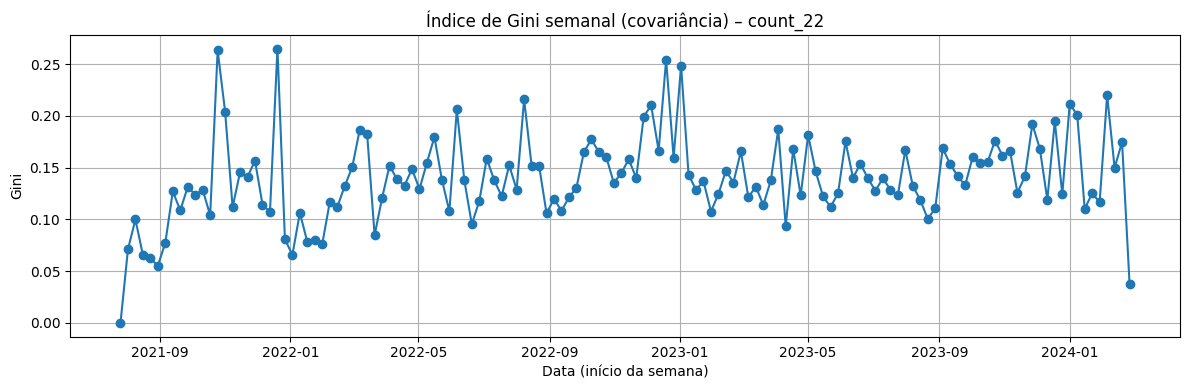

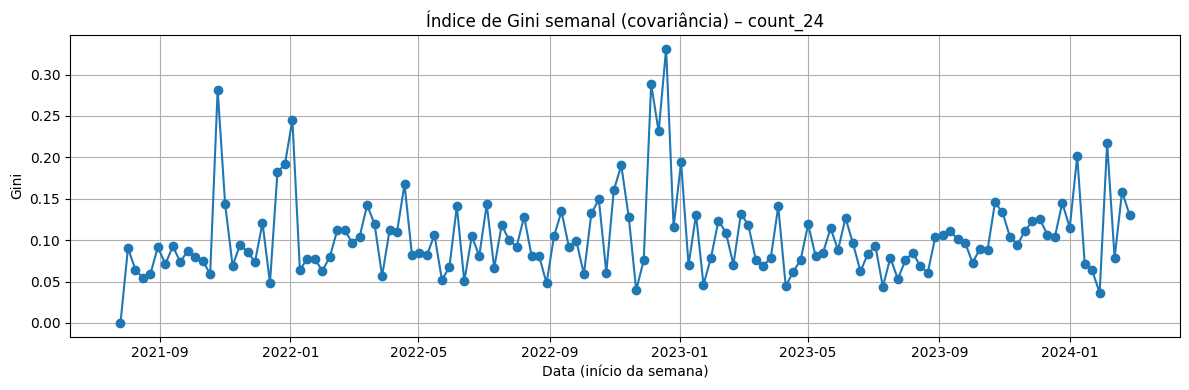

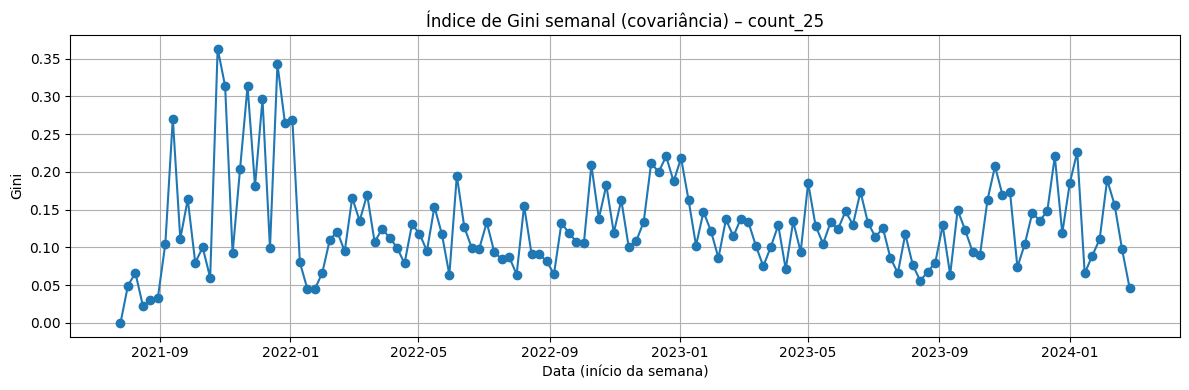

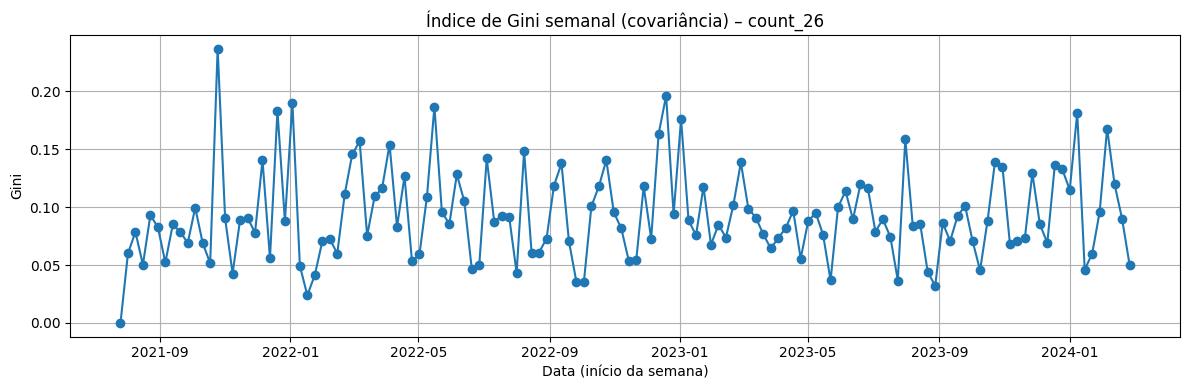

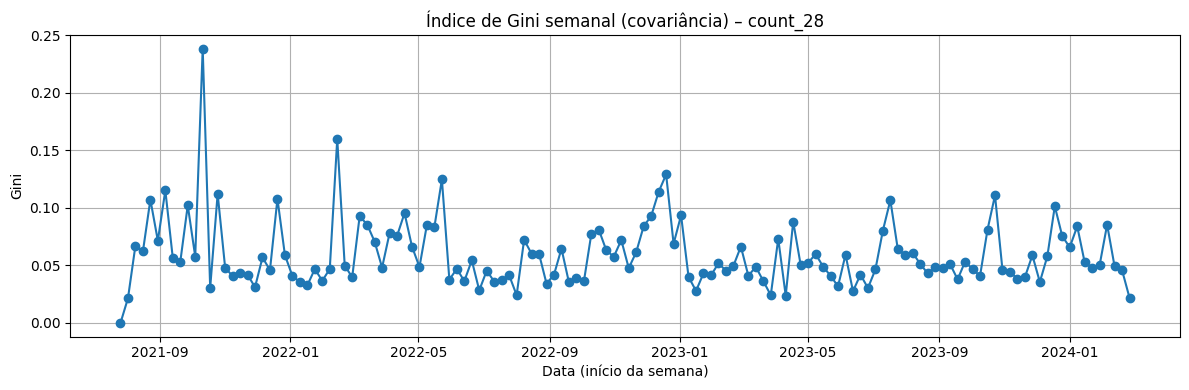

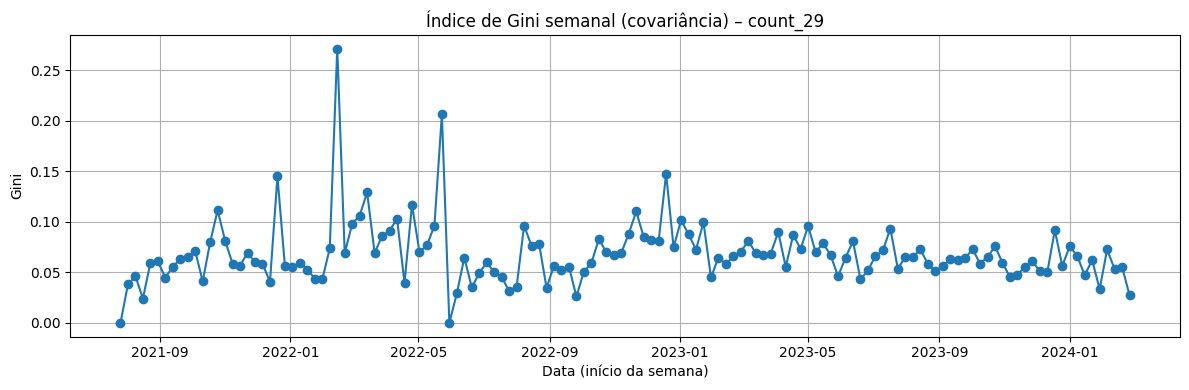

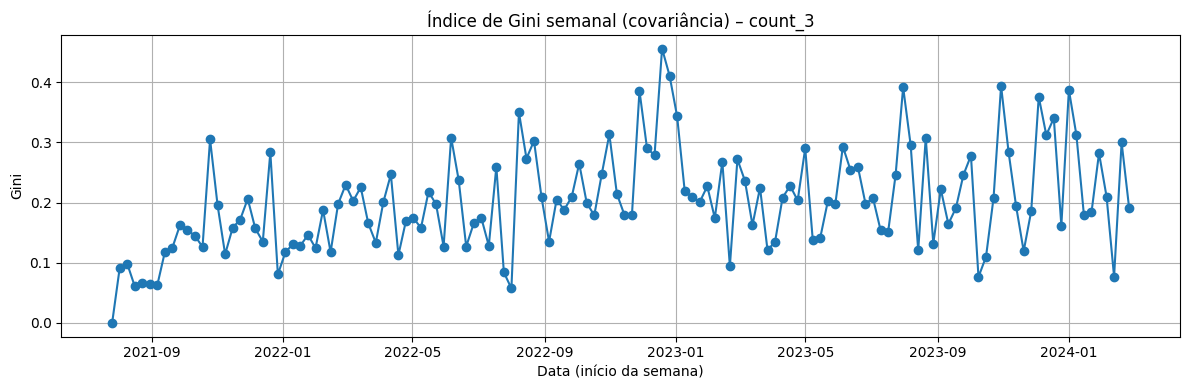

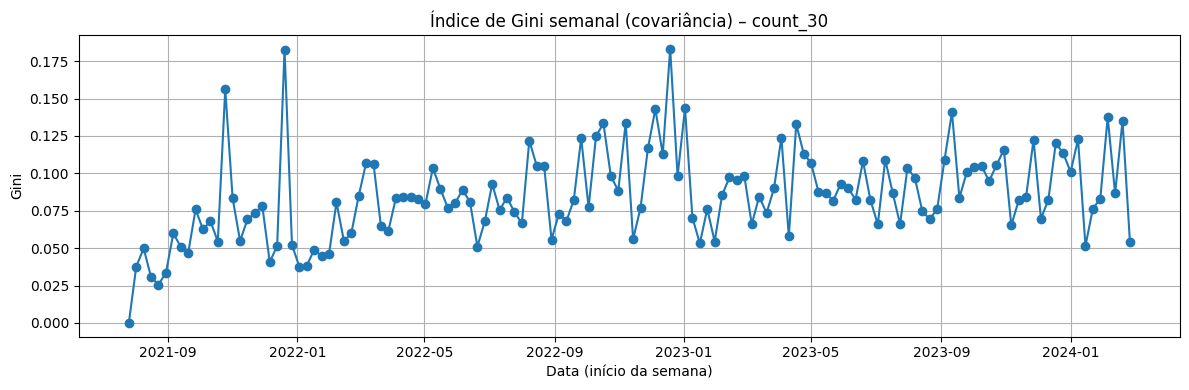

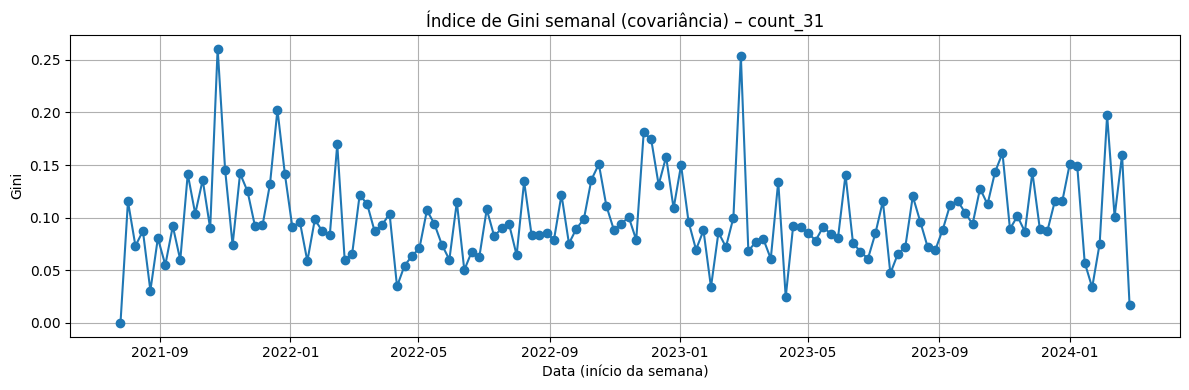

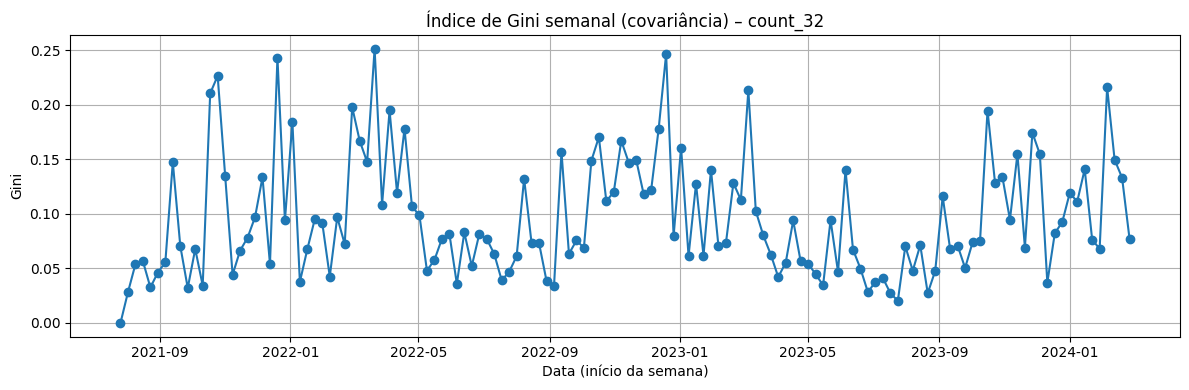

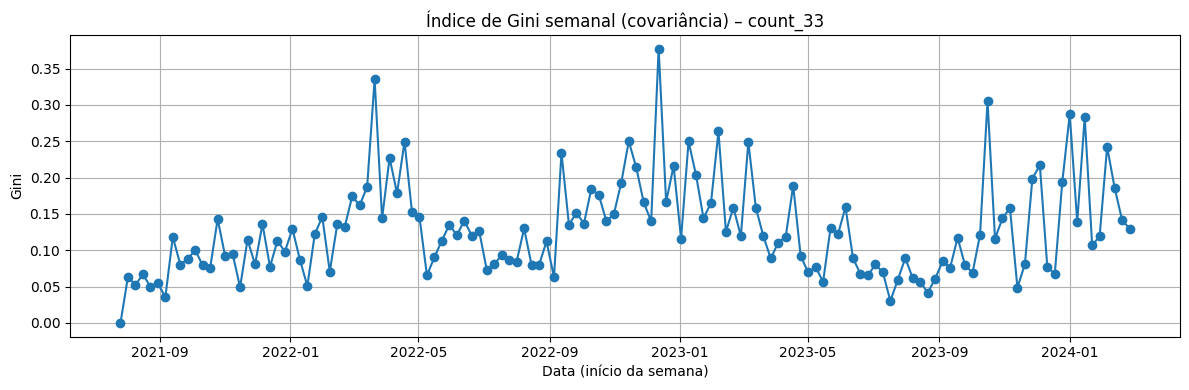

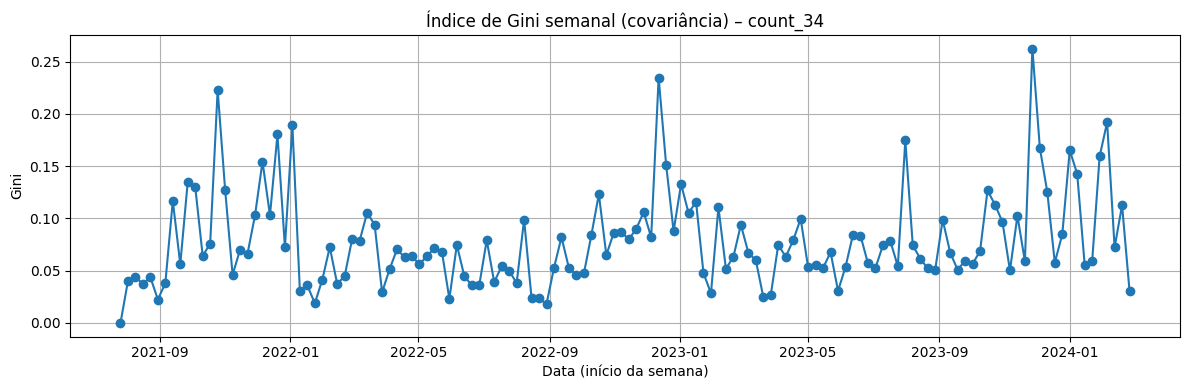

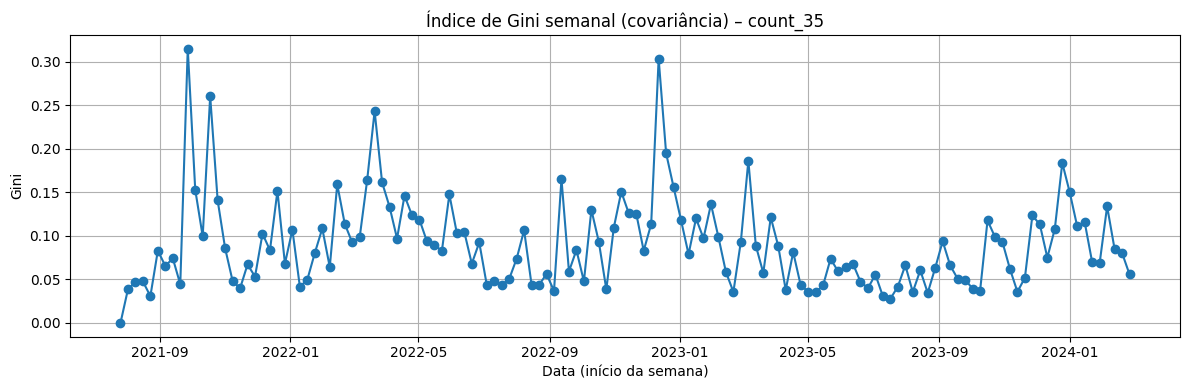

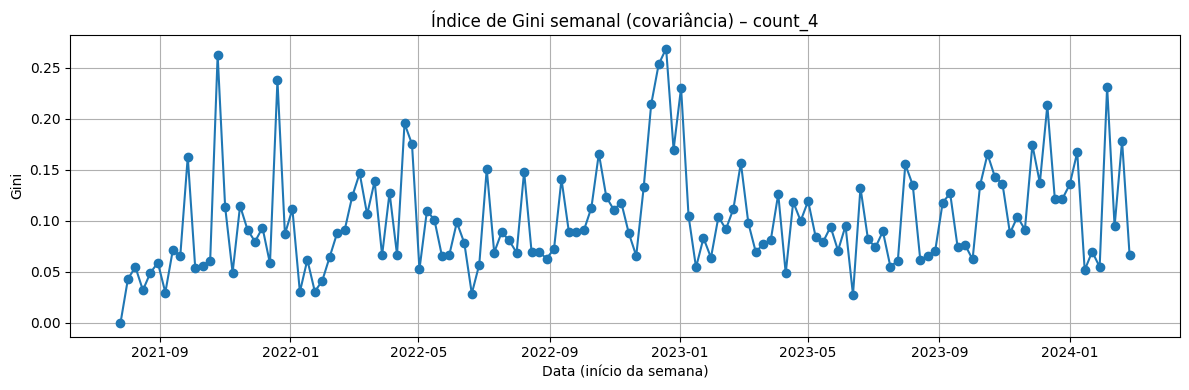

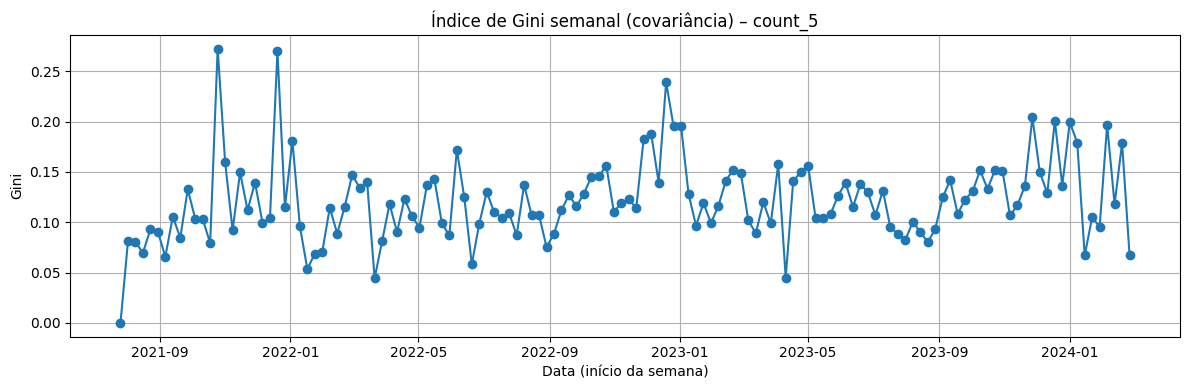

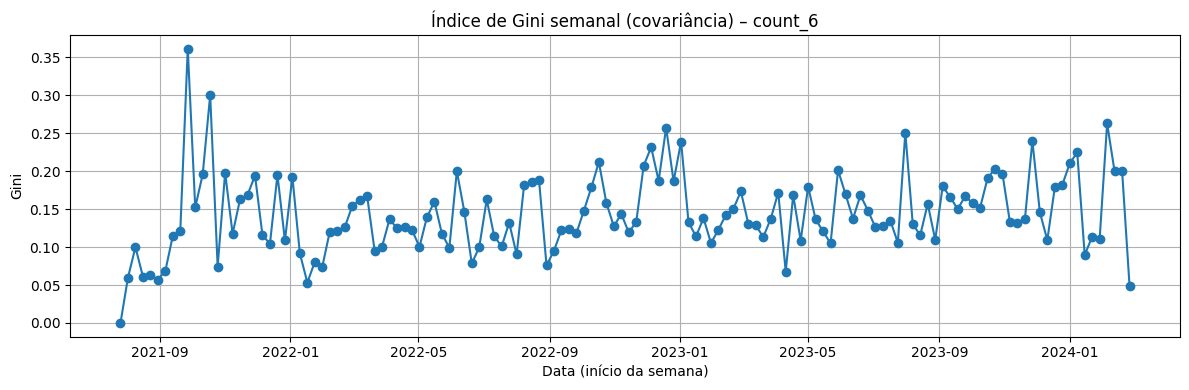

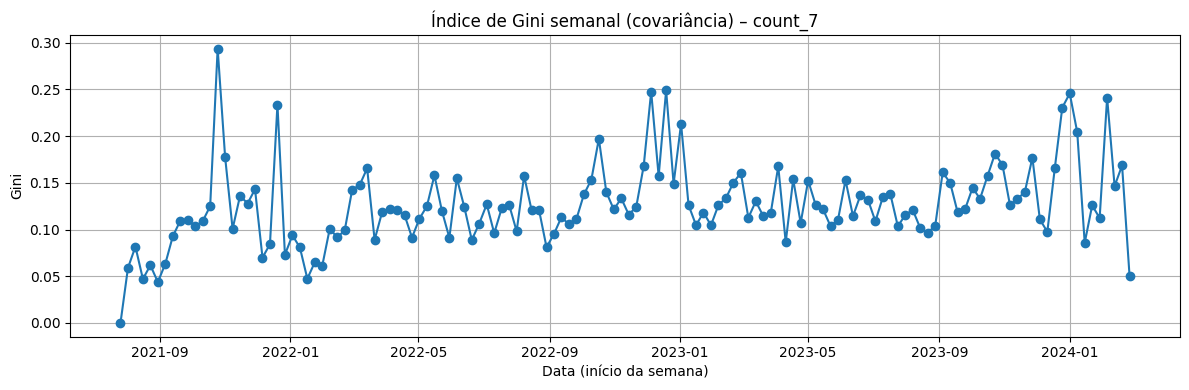

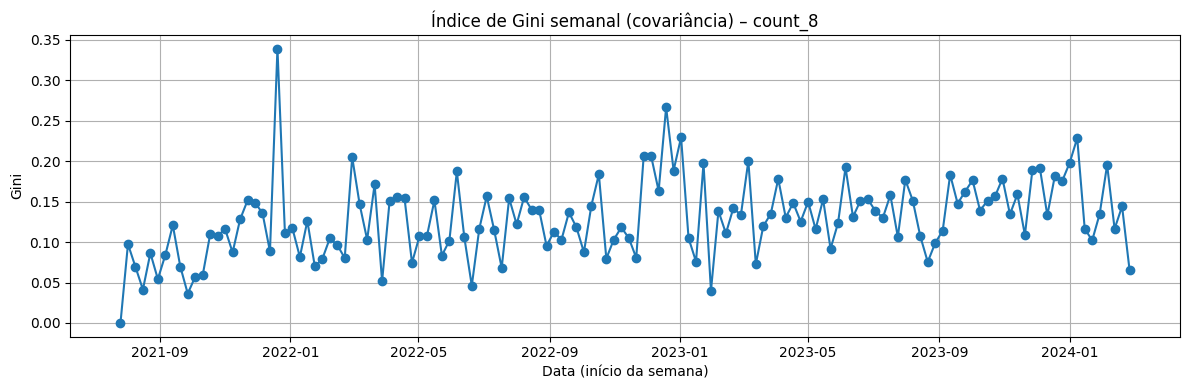

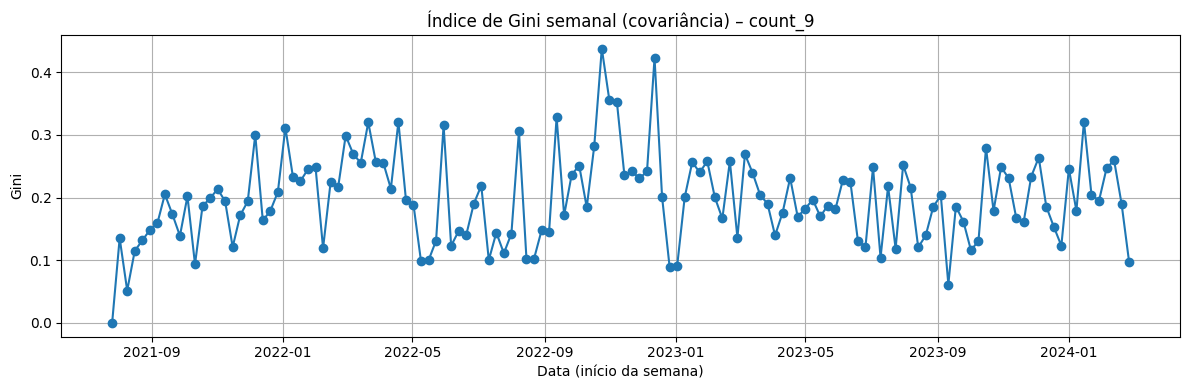

In [ ]:
df_resultado_gini = gini_cov_semanal(df_corrigido_total, plotar=True)
